# 0. Introduction

앞서서 Logistic Regression / Linear SVC / RF 모델들을 사용해보았다.

차원 축소 기법으로 PCA보다는 LDA 기법을 쓰는게 더 효과적이였다.

대체로 성능에 큰 차이는 없었지만, raw data가 워낙 정제가 잘 되어있고, 깔끔해서인지 아무것도 하지 않았을 때 Accuracy가 0.966407로 가장 좋았다.

한편으로 HAR 데이터에 관해서 조금 더 공부를 해보니 시계열로 접근하는 것이 더 좋은 방법일 수 있겠다는 생각이 들었다.

HAR (Human Activity Recognition) 데이터셋은 시간에 따른 센서 데이터로 구성된 이유는 사람의 활동이 시간에 따라 변화하는 동적인 과정이기 때문이다. 

즉, 사람의 활동은 일종의 시퀀스(sequence)로 발생하는 연속적인 사건이기 때문에, 이를 정확히 예측하려면 시간의 흐름에 따른 정보를 고려해야 한다.

사람의 활동은 특정 시점에 ‘단 한 번’ 발생하는 것이 아니라, 시간에 따라 연속적으로 변화하는 동적인 과정이다. 

예를 들어, 걷기나 앉기와 같은 활동은 각 시점에서의 작은 변화들이 모여 하나의 활동을 이룬다. 

이러한 시간적 의존성을 반영하기 위해, 활동 예측 문제는 시계열 데이터로 접근하는 것이 중요하다고 한다. 

시계열 모델은 시간에 따른 변화 패턴을 학습하여, 과거의 정보가 현재와 미래에 어떤 영향을 미치는지를 파악할 수 있다. 

따라서 사람의 움직임을 정확히 예측하기 위해서는 연속적인 시간 스텝의 정보를 모두 고려하는 시계열 접근 방식이 필수적이라고 한다.

아래의 링크를 참고하여 코드를 작성하였습니다.

https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/blob/master/LSTM.ipynb

# 1. Environment and Setup

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import optuna
import seaborn as sns

/opt/anaconda3/envs/myenv3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Device Configuration

In [2]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [3]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# 2. Data Preparation

## Data loading functions

In [4]:
def load_x(x_signals_paths):
    x_signals = []
    for signal_type_path in x_signals_paths:
        with open(signal_type_path, 'r') as file:
            x_signals.append(
                np.array([np.array(row.strip().split(), dtype=np.float32) for row in file])
            )
    return np.transpose(np.array(x_signals), (1, 2, 0))

def load_y(y_path):
    with open(y_path, 'r') as file:
        y_ = np.array([int(row.strip()) for row in file])
    return y_ - 1

## Dataset Path

In [5]:
dataset_path = "/Users/seojeongmin/Desktop/study/Human_Activity_Recognition/dataset/human+activity+recognition+using+smartphones/UCI HAR Dataset/"
train_path = "train/"
test_path = "test/"

In [6]:
input_signal_types = [
    "body_acc_x_", "body_acc_y_", "body_acc_z_",
    "body_gyro_x_", "body_gyro_y_", "body_gyro_z_",
    "total_acc_x_", "total_acc_y_", "total_acc_z_"
]

labels = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]


## Loading datasets

In [7]:
x_train_signals_paths = [dataset_path + train_path + "Inertial Signals/" + signal + "train.txt" for signal in input_signal_types]
x_test_signals_paths = [dataset_path + test_path + "Inertial Signals/" + signal + "test.txt" for signal in input_signal_types]
x_train = load_x(x_train_signals_paths)
x_test = load_x(x_test_signals_paths)

y_train_path = dataset_path + train_path + "y_train.txt"
y_test_path = dataset_path + test_path + "y_test.txt"
y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


## Preprocessing data

In [8]:
def preprocess_data(x, y):
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)
    x = (x - x.mean()) / x.std()
    return x, y

n_classes = 6
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

## Split into train/validation sets

In [9]:
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_train, y_train, test_size=0.2, random_state=SEED
)

In [10]:
x_train_split = torch.tensor(x_train_split, dtype=torch.float32)
y_train_split = torch.tensor(y_train_split, dtype=torch.long)
x_val_split = torch.tensor(x_val_split, dtype=torch.float32)
y_val_split = torch.tensor(y_val_split, dtype=torch.long)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

/var/folders/c9/nxk21wmd5bg9s7hvn7zq2rhw0000gn/T/ipykernel_31789/3504305607.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_split = torch.tensor(x_train_split, dtype=torch.float32)
/var/folders/c9/nxk21wmd5bg9s7hvn7zq2rhw0000gn/T/ipykernel_31789/3504305607.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_split = torch.tensor(y_train_split, dtype=torch.long)
/var/folders/c9/nxk21wmd5bg9s7hvn7zq2rhw0000gn/T/ipykernel_31789/3504305607.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_split = torch.tensor(x_val_

In [11]:
train_dataset = TensorDataset(x_train_split, y_train_split)
val_dataset = TensorDataset(x_val_split, y_val_split)
test_dataset = TensorDataset(x_test, y_test)

# 3. Model and Hyperparameter Tuning

## 3.1 LSTM Model Definition

In [12]:
class HARModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(HARModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

## Hyperparameter tuning with Optuna

In [13]:
def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 32, 128)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = HARModel(x_train_split.shape[2], hidden_size, n_classes, dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(10):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(x_batch)
            val_loss += criterion(outputs, y_batch).item()

    return -val_loss

In [14]:
study = optuna.create_study(direction="maximize", study_name="LSTM Optimization")
study.optimize(objective, n_trials=10)

[I 2024-11-24 18:00:49,435] A new study created in memory with name: LSTM Optimization
[I 2024-11-24 18:01:13,626] Trial 0 finished with value: -7.909982157871127 and parameters: {'hidden_size': 48, 'dropout_rate': 0.1950867695029834, 'learning_rate': 0.009571132355366493, 'batch_size': 32}. Best is trial 0 with value: -7.909982157871127.
[I 2024-11-24 18:01:38,043] Trial 1 finished with value: -20.995987832546234 and parameters: {'hidden_size': 115, 'dropout_rate': 0.47724635848216, 'learning_rate': 0.0065366753010476075, 'batch_size': 64}. Best is trial 0 with value: -7.909982157871127.
[I 2024-11-24 18:02:04,163] Trial 2 finished with value: -6.2632976695895195 and parameters: {'hidden_size': 68, 'dropout_rate': 0.31128310067890513, 'learning_rate': 0.006281574577314419, 'batch_size': 32}. Best is trial 2 with value: -6.2632976695895195.
[I 2024-11-24 18:02:32,898] Trial 3 finished with value: -5.612614941783249 and parameters: {'hidden_size': 90, 'dropout_rate': 0.4758445105649436,

## Best Params 저장 및 로드

In [15]:
best_params = study.best_params

## Define checkpoint directory and paths

In [16]:
checkpoint_dir = "./checkpoints/"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "model_checkpoint.pth")
best_params_path = os.path.join(checkpoint_dir, "best_params.json")

In [17]:
with open(best_params_path, "w") as f:
    json.dump(best_params, f)

In [18]:
with open(best_params_path, "r") as f:
    best_params = json.load(f)

# 4. Model Training and Checkpointing

In [19]:
batch_size = best_params["batch_size"]
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = HARModel(
    input_size=x_train_split.shape[2],
    hidden_size=best_params["hidden_size"],
    output_size=n_classes,
    dropout_rate=best_params["dropout_rate"]
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"])
start_epoch = 0

## Optionally load checkpoint

In [24]:
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"]
    print(f"Resuming training from epoch {start_epoch}")

train_losses = []
val_losses = []
best_val_loss = float("inf")
num_epochs = 50

for epoch in range(start_epoch, num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x_batch.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * x_batch.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }, checkpoint_path)
        print(f"Best model saved at epoch {epoch + 1}")

    print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

Best model saved at epoch 1
Epoch 1/50: Train Loss = 1.1845, Val Loss = 0.8617
Best model saved at epoch 2
Epoch 2/50: Train Loss = 0.6804, Val Loss = 0.5144
Best model saved at epoch 3
Epoch 3/50: Train Loss = 0.4589, Val Loss = 0.3036
Best model saved at epoch 4
Epoch 4/50: Train Loss = 0.2522, Val Loss = 0.2225
Best model saved at epoch 5
Epoch 5/50: Train Loss = 0.2044, Val Loss = 0.1736
Epoch 6/50: Train Loss = 0.1716, Val Loss = 0.2102
Best model saved at epoch 7
Epoch 7/50: Train Loss = 0.1548, Val Loss = 0.1453
Epoch 8/50: Train Loss = 0.1612, Val Loss = 0.1702
Best model saved at epoch 9
Epoch 9/50: Train Loss = 0.1373, Val Loss = 0.1411
Best model saved at epoch 10
Epoch 10/50: Train Loss = 0.1124, Val Loss = 0.1344
Best model saved at epoch 11
Epoch 11/50: Train Loss = 0.1088, Val Loss = 0.1317
Epoch 12/50: Train Loss = 0.1347, Val Loss = 0.1337
Epoch 13/50: Train Loss = 0.1168, Val Loss = 0.1338
Epoch 14/50: Train Loss = 0.1257, Val Loss = 0.1749
Best model saved at epoch 1

## loss curves

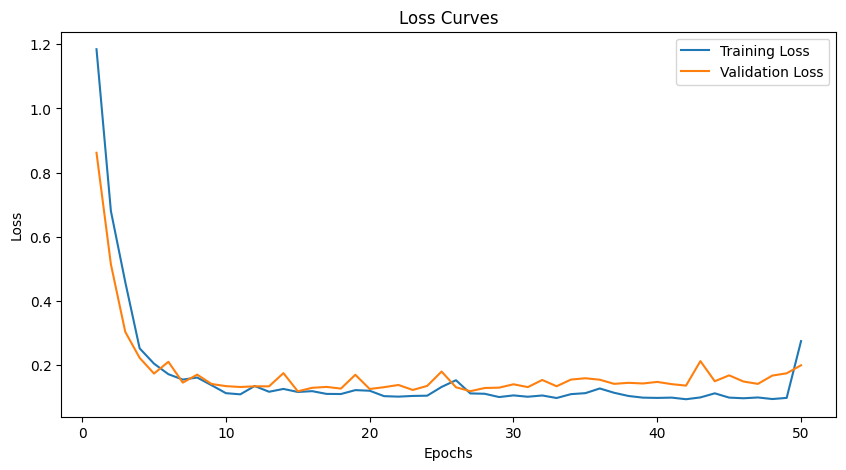

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 5. Evaluation and Visualization

In [26]:
model.eval()
test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * x_batch.size(0)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

test_loss = test_loss / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=labels))

Test Loss: 0.3532

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.89      0.95      0.92       496
  WALKING_UPSTAIRS       0.85      0.87      0.86       471
WALKING_DOWNSTAIRS       0.96      0.91      0.93       420
           SITTING       0.88      0.74      0.80       491
          STANDING       0.78      0.91      0.84       532
            LAYING       1.00      0.95      0.98       537

          accuracy                           0.89      2947
         macro avg       0.89      0.89      0.89      2947
      weighted avg       0.89      0.89      0.89      2947



## Confusion Matrix

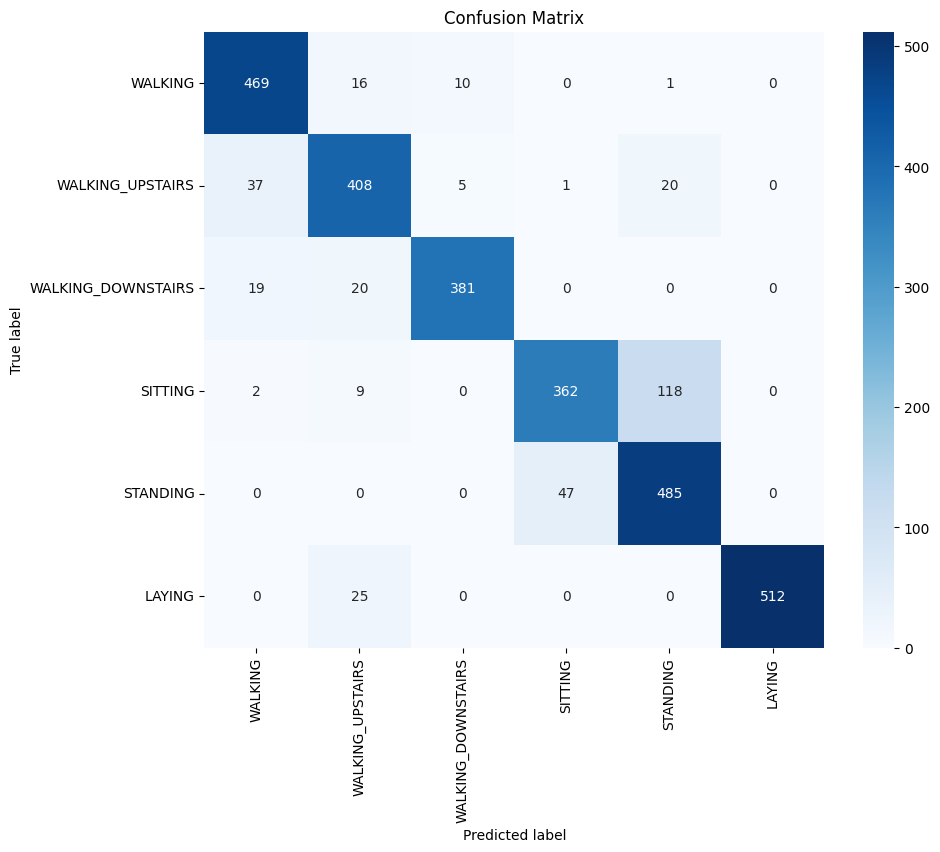

In [27]:
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# 6. Conclusion

- 모델은 전체적으로 높은 정확도와 성능을 보임.

- SITTING과 STANDING은 정적인 행동이라서인지 다른 클래스에 비해서는 낮음.